In [1]:
from __future__ import division, print_function
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib.pyplot as plt

#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('png', 'pdf')

import seaborn as sns
plt.rcParams['lines.linewidth'] = 0.75

import numpy as np
import pandas as pd
def df_repr_latex(self):
    return '\n'.join([
        r'\vspace{5mm}',
        r'{\scriptsize{\centering{%s}}}' % self.to_latex(),
        r'\vspace{5mm}'
    ])
pd.DataFrame._repr_latex_ = df_repr_latex
from pandas.io.formats.style import Styler
Styler._repr_latex_ = lambda s: s.data._repr_latex_()

class HTMLLatex:
    def __init__(self, html, latex):
        self.html = html
        self.latex = latex
    def _repr_html_(self): return self.html
    def _repr_latex_(self): return self.latex
NewPage = HTMLLatex('<hr>', r'\clearpage\newpage')

from IPython.display import display, HTML, Latex

from dcmfetch import fetch_series
from mriqa.reports import (
    ghosting_report, slice_profile_report, distortion_report,
    piqt_distortion_report, snr_report_multi,
    resolution_bars_report, uniformity_report, snr_report
)
from mriqa.phantoms import SIEMENSLONGBOTTLE, PIQTSP

from mriqa.xmlqa.coilqa import (
    find_qa_results_file,
    coil_snr, coil_snr_history, coil_name, coil_names,
    plot_coil_images, 
    MINCOILSERNO
)

from dcmextras.siemenscsa import csa, phoenix

# Percent above specification
MARGIN = 5 
margin_colour = lambda x: 'color: %s' % ('green' if x>= MARGIN else 'orange' if x>0 else 'red')
ok_colour     = lambda x: 'color: %s' % ('green' if x else 'red')

from datetime import datetime

import fmriqa

## Summary
Tests Performed:

- Slice Shape and Profile
- Distortion and Field of View
- In Plane Resolution
- Ghosting
- Head Coil SNR
- Head Coil Image Uniformity

All of the above are acceptable.

In [2]:
text = '''
R. Hartley-Davies, J. Delve. S. Curtis, H. Elbert
Medical Physics & Bioengineering, UH Bristol
December 2018
'''
display(HTMLLatex(
    r'<pre>' + text + r'</pre>',
    r'\vfill' + '\n' + r'\begin{verbatim}' + '\n' + text + '\n' + r'\end{verbatim}' + '\n'
))


In [3]:
NewPage

## Slice Profile

### TO2 Phantom

These are the profiles of 3mm and 5mm slices measured with TO2 for a conventional spin echo with a T<sub>R</sub> of 500ms and a T<sub>E</sub> of 30ms.

In [4]:
# TO2: Slice 3mm
patid = 'PQA20181213BCH3Y'
stuid = '1'

# Distortion Corrected, Phase RL, Uniformity Corrected 512*512
dobjs = fetch_series(patid, stuid, sernos=[42])
slice_idx = 0
results = slice_profile_report(dobjs[slice_idx], flipped_ud=False, flipped_rl=False)

Plate Angle  =  11.7 degrees
FWHM     (1) =  64.0 pixels, or 3.2 mm
FWHM     (2) =  66.2 pixels, or 3.3 mm
FWHM (GMEAN) =  65.1 pixels, or 3.3 mm


In [5]:
# TO2: Slice 5mm
# Distortion Corrected, Phase RL, Uniformity Corrected 512*512
dobjs = fetch_series(patid, stuid, sernos=[40])
slice_idx = 0
result = slice_profile_report(dobjs[slice_idx], flipped_ud=False, flipped_rl=False)
results = results.append(result)

Plate Angle  =  11.7 degrees
FWHM     (1) =  104.6 pixels, or 5.3 mm
FWHM     (2) =  107.6 pixels, or 5.4 mm
FWHM (GMEAN) =  106.1 pixels, or 5.4 mm


In [6]:
pd.set_option('precision', 1)
results[['FWHMGMeanPixels', 'FWHMGMeanMM']].rename(columns={
    'FWHMGMeanPixels': 'Projected FWHM (pixels)',
    'FWHMGMeanMM': 'True FWHM (mm)'
})

Projected FWHM (pixels)  True FWHM (mm)
SliceThickness                                         
3.0                                65.1             3.3
5.0                               106.1             5.4

These are both with the AAPM tolerance of 0.5mm.

In [7]:
NewPage

### PIQT Phantom

These are the profiles of 3mm and 5mm slices measured with the PIQT phantom for a conventional spin echo with a T<sub>R</sub> of 500ms and a T<sub>E</sub> of 30ms. This is currently for comparison purposes only.

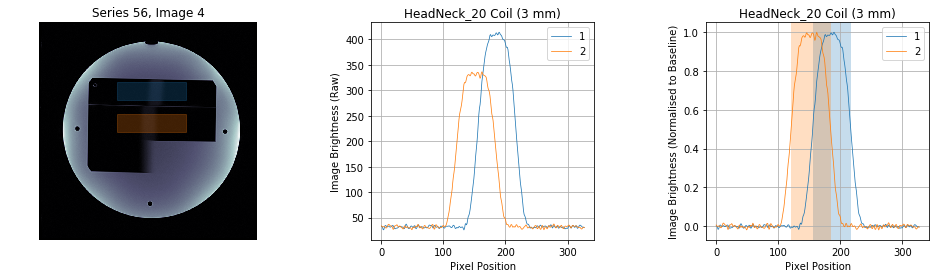

Plate Angle  =  11.7 degrees
FWHM     (1) =  61.2 pixels, or 3.1 mm
FWHM     (2) =  63.7 pixels, or 3.2 mm
FWHM (GMEAN) =  62.4 pixels, or 3.2 mm


In [8]:
# PIQT 3 mm Slice
# Distortion Corrected, Phase RL, Non-Uniformity Corrected 512*512
dobjs = fetch_series(patid, stuid, sernos=[56])
slice_idx = 3
results = slice_profile_report(dobjs[slice_idx], phantom=PIQTSP, flipped_ud=False, flipped_rl=False)

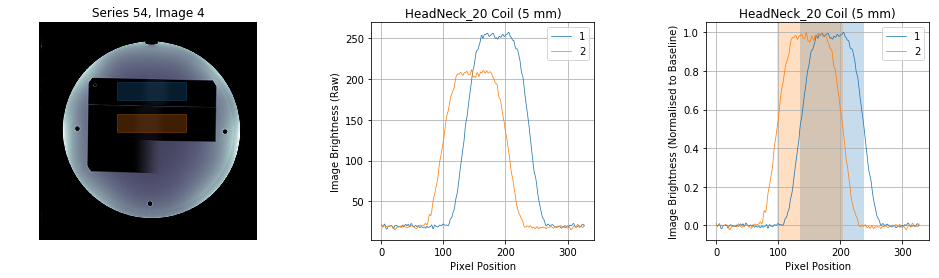

Plate Angle  =  11.7 degrees
FWHM     (1) =  103.6 pixels, or 5.2 mm
FWHM     (2) =  106.3 pixels, or 5.4 mm
FWHM (GMEAN) =  104.9 pixels, or 5.3 mm


In [9]:
# PIQT 5 mm Slice
# Distortion Corrected, Phase RL, Non-Uniformity Corrected 512*512
dobjs = fetch_series(patid, stuid, sernos=[54])
slice_idx = 3
results = results.append(
    slice_profile_report(dobjs[slice_idx], phantom=PIQTSP, flipped_ud=False, flipped_rl=False)
)

In [10]:
results[['FWHMGMeanPixels', 'FWHMGMeanMM']].rename(columns={
    'FWHMGMeanPixels': 'Projected FWHM (pixels)',
    'FWHMGMeanMM': 'True FWHM (mm)'
})

Projected FWHM (pixels)  True FWHM (mm)
SliceThickness                                         
3.0                                62.4             3.2
5.0                               104.9             5.3

In [11]:
NewPage

## Geometric Distortion and Scaling

### TO2 Phantom

The TO2 phantom has a square box for distortion and scale measurements.

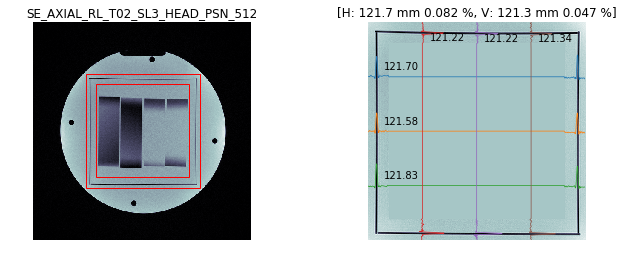

Horizontal Scale / Distortion:    121.7 mm / 0.08 %
Vertical Scale / Distortion:      121.3 mm / 0.05 %


In [12]:
# TO2: Distortion
# SE: Axial, Phase RL, 512 matrix
dobjs = fetch_series(patid, stuid, sernos=[41])

slice_idx = len(dobjs) // 2
results = distortion_report(dobjs[slice_idx], flipped_ud=False, flipped_rl=False)

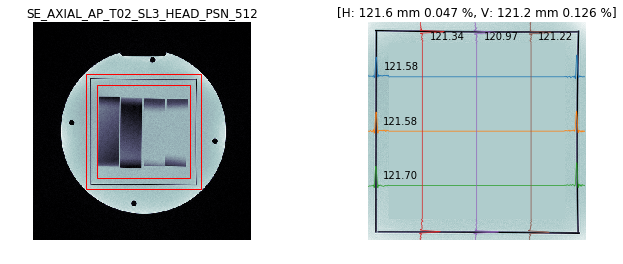

Horizontal Scale / Distortion:    121.6 mm / 0.05 %
Vertical Scale / Distortion:      121.2 mm / 0.13 %


In [13]:
# TO2: Distortion
# SE: Axial, Phase AP, 512 matrix
dobjs = fetch_series(patid, stuid, sernos=[43])

slice_idx = len(dobjs)//2
pd.set_option('precision', 3)
results = results.append(distortion_report(dobjs[slice_idx], flipped_ud=False, flipped_rl=False))

In [14]:
pd.set_option('precision', 3)
results[[
    'Orientation', 'PhaseDirection', 'Sensitivity',
    'HorizontalScale', 'HorizontalDistortion',
    'VerticalScale', 'VerticalDistortion'
]].rename(columns={
    'PhaseDirection': 'Phase Direction',
    'HorizontalScale': 'Horizontal Scale (mm)', 'HorizontalDistortion':'Horizontal Distortion',
    'VerticalScale': 'Vertical Scale (mm)', 'VerticalDistortion': 'Vertical Distortion'  
})

Orientation Phase Direction  Sensitivity  Horizontal Scale (mm)  \
Series                                                                   
41           Axial              RL        0.239                121.704   
43           Axial              AP        0.239                121.623   

        Horizontal Distortion  Vertical Scale (mm)  Vertical Distortion  
Series                                                                   
41                      0.082              121.257                0.047  
43                      0.047              121.175                0.126

The size of the phantom box is slightly greater in both directions than the nominal value of 120mm. This just outside the usual tolerance of 1mm. It is unlikely to cause issues in routine imaging but if the scanner is to be used for radiotherapy planning then the gradient sensitivity adjustment should be repeated at the next opportunity to ensure the image scale is within radiotherapy physics tolerances.

Distortion (arising from both residual gradient nonlinearity and static field inhomogeneity) is acceptable at the bandwidth used (130Hz/pixel).

In [15]:
NewPage

### PIQT Phantom

The PIQT phantom has a grid for distortion and scaling. This is currently for comparison purposes only.

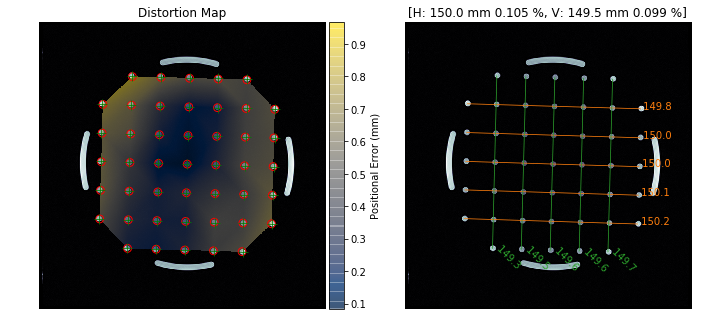

Horizontal Scale / Distortion:    150.0 mm / 0.10 %
Vertical Scale / Distortion:      149.5 mm / 0.10 %


In [16]:
# PIQT: Distortion
# SE: Axial, Phase RL, 512 matrix
dobjs = fetch_series(patid, stuid, sernos=[56])
slice_idx = 1
results = piqt_distortion_report(dobjs[slice_idx])

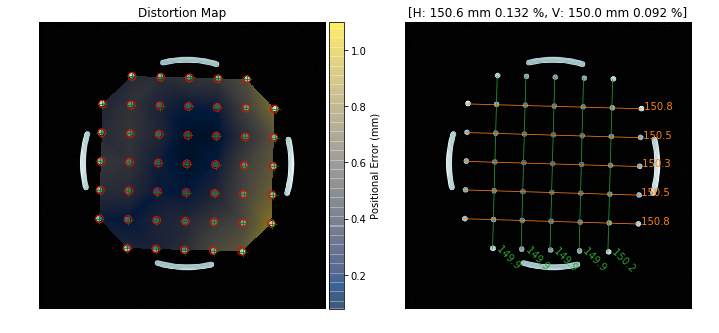

Horizontal Scale / Distortion:    150.6 mm / 0.13 %
Vertical Scale / Distortion:      150.0 mm / 0.09 %


In [17]:
# PIQT: Distortion
# SE: Axial, Phase AP, 512 matrix
dobjs = fetch_series(patid, stuid, sernos=[58])
slice_idx = 1
results = results.append(piqt_distortion_report(dobjs[slice_idx]))

In [18]:
pd.set_option('precision', 3)
results[[
    'Orientation', 'PhaseDirection', 'Sensitivity',
    'HorizontalScale', 'HorizontalDistortion',
    'VerticalScale', 'VerticalDistortion'
]].rename(columns={
    'PhaseDirection': 'Phase Direction',
    'HorizontalScale': 'Horizontal Scale (mm)', 'HorizontalDistortion':'Horizontal Distortion',
    'VerticalScale': 'Vertical Scale (mm)', 'VerticalDistortion': 'Vertical Distortion'  
})

Orientation Phase Direction  Sensitivity  Horizontal Scale (mm)  \
Series                                                                   
56           Axial              RL        0.239                150.016   
58           Axial              AP        0.239                150.589   

        Horizontal Distortion  Vertical Scale (mm)  Vertical Distortion  
Series                                                                   
56                      0.105              149.519                0.099  
58                      0.132              149.964                0.092

In [19]:
NewPage

## Spatial Resolution

The resolution is assessed using the TO4 phantom, which has parallel plates of various separations. These are results for the highest resolution scan (1024x1024).

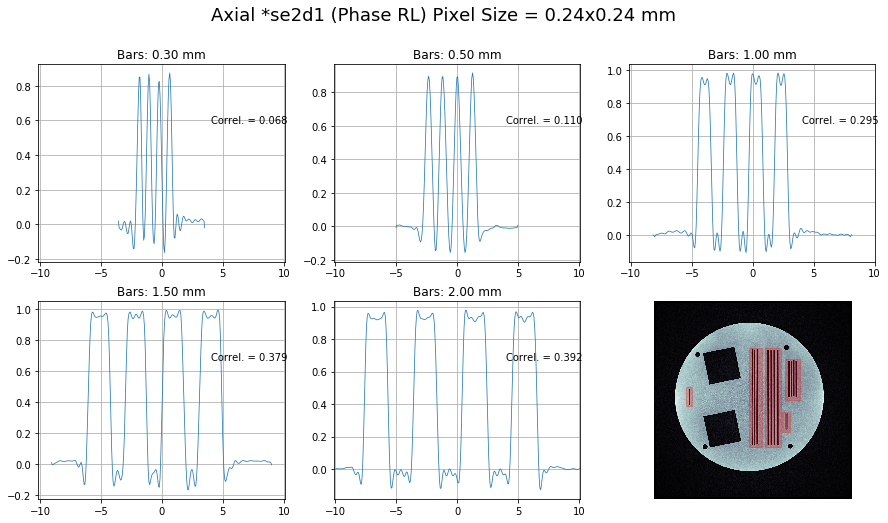

In [20]:
# TO4: Resolution
dobjs = fetch_series(patid, stuid, sernos=[50])
slice_idx = 0
result = resolution_bars_report(dobjs[slice_idx], flipped_ud=False, flipped_rl=True)

All the features are adequately resolved.

In [21]:
NewPage

## Ghosting

Image ghosting following the approach of [AAPM report 100](https://www.aapm.org/pubs/reports/RPT_100.pdf) for the axial orientation.

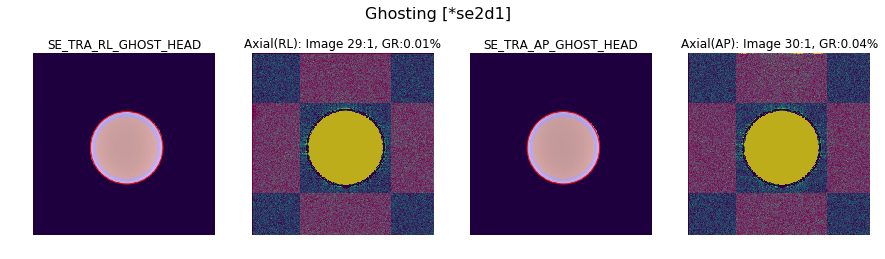

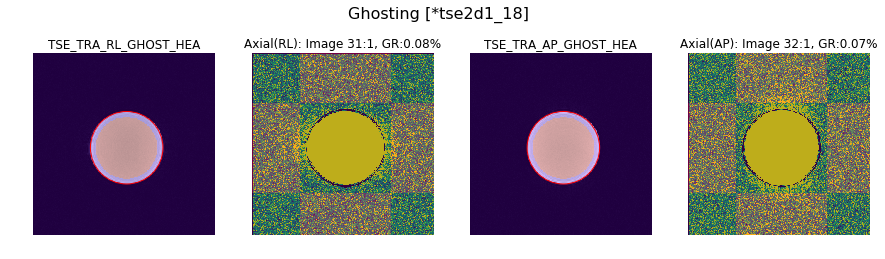

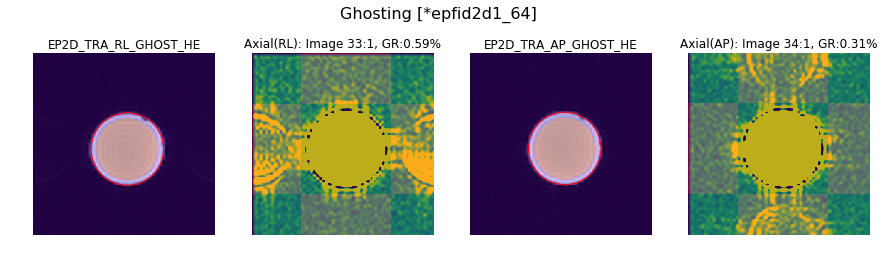

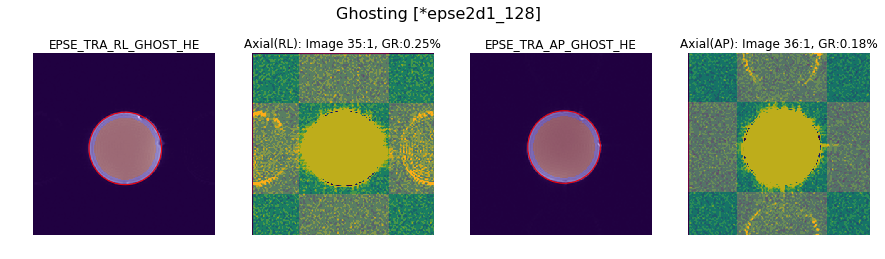

Sequence Orientation Phase Direction  Ghost Ratio (%)
Series                                                           
29            *se2d1       Axial              RL            0.009
30            *se2d1       Axial              AP            0.043
31        *tse2d1_18       Axial              RL            0.076
32        *tse2d1_18       Axial              AP            0.070
33      *epfid2d1_64       Axial              RL            0.588
34      *epfid2d1_64       Axial              AP            0.314
35      *epse2d1_128       Axial              RL            0.249
36      *epse2d1_128       Axial              AP            0.177

In [22]:
# GE10CM: Ghosting

# SE Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in [29, 30]]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = ghosting_report(dobjs, axes=list(axs.flat))

# TSE18 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in [31, 32]]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))

# EPI64 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in [33, 34]]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))
plt.show()

# EPISE128 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in [35, 36]]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))
plt.show()

with pd.option_context('display.precision', 3):
    display(
        results[['Sequence', 'Orientation', 'PhaseDirection', 'GhostRatio']].rename(columns={
            'PhaseDirection': 'Phase Direction', 'GhostRatio': 'Ghost Ratio (%)'
        })
    )

The level of ghosting is low (less than 1% for SE, TSE, EPI and SE-EPI).

In [23]:
NewPage

## Receiver Coil Uniformity

We have tested the uniformity of the standard head/neck coil using a silicone oil (or water) filled spherical phantom. Results are presented both before and after Siemens `prescan-normalise` intensity correction.

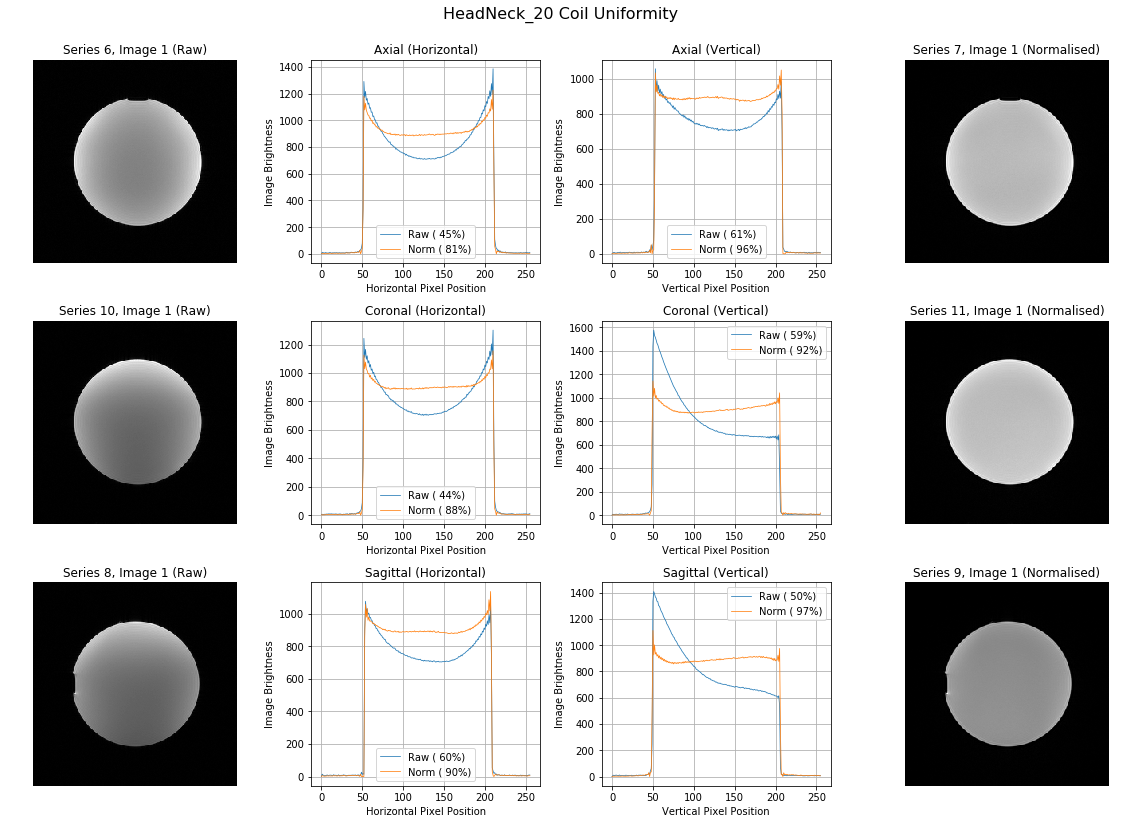

Raw Images


Series No.                         Protocol         Axis  \
Orientation                                                             
Axial                 6  SE_TRA_RL_UNIF_HEAD_OIL20CM_PSN     Axial/RL   
Coronal              10  SE_COR_FH_UNIF_HEAD_OIL20CM_PSN   Coronal/HF   
Sagittal              8  SE_SAG_AP_UNIF_HEAD_OIL20CM_PSN  Sagittal/AP   

              X Uniformity (%)  Y Uniformity (%)  
Orientation                                       
Axial                    45.34             60.51  
Coronal                  44.10             59.24  
Sagittal                 59.62             50.32

Intensity Normalised Images


Series No.                         Protocol         Axis  \
Orientation                                                             
Axial                 7  SE_TRA_RL_UNIF_HEAD_OIL20CM_PSN     Axial/RL   
Coronal              11  SE_COR_FH_UNIF_HEAD_OIL20CM_PSN   Coronal/HF   
Sagittal              9  SE_SAG_AP_UNIF_HEAD_OIL20CM_PSN  Sagittal/AP   

              X Uniformity (%)  Y Uniformity (%)  
Orientation                                       
Axial                    81.37             96.18  
Coronal                  87.58             92.41  
Sagittal                 89.74             96.84

In [24]:
# OILSPHERE: Uniformity
# SE Axial,Coronal,Sagittal; w w/o Intensity Normalization
raw_tra = fetch_series(patid, stuid, sernos=[6])
psn_tra = fetch_series(patid, stuid, sernos=[7])
raw_sag = fetch_series(patid, stuid, sernos=[8])
psn_sag = fetch_series(patid, stuid, sernos=[9])
raw_cor = fetch_series(patid, stuid, sernos=[10])
psn_cor = fetch_series(patid, stuid, sernos=[11])

if len(raw_tra) > 1:
    results = uniformity_report(
        raw_dobjs=[raw_tra[0], raw_sag[0], raw_cor[0]],
        psn_dobjs=[psn_tra[0], psn_sag[0], psn_cor[0]],
        raw_dobjsb=[raw_tra[1], raw_sag[1], raw_cor[1]],
        psn_dobjsb=[psn_tra[1], psn_sag[1], psn_cor[1]]
    )
else:
    results = uniformity_report(
        raw_dobjs=[raw_tra[0], raw_sag[0], raw_cor[0]],
        psn_dobjs=[psn_tra[0], psn_sag[0], psn_cor[0]],
    )

plt.show()

with pd.option_context('display.precision', 2):
    print('Raw Images')
    display(
        results[['SeriesRaw',  'ProtocolRaw',  'OrientRaw', 'XUniformityRaw', 'YUniformityRaw']].rename(columns={
            'SeriesRaw': 'Series No.', 'ProtocolRaw': 'Protocol', 'OrientRaw': 'Axis',
            'XUniformityRaw': ' X Uniformity (%)', 'YUniformityRaw': 'Y Uniformity (%)'
        })
    )
    print('Intensity Normalised Images')
    display(
        results[['SeriesNorm', 'ProtocolNorm', 'OrientNorm', 'XUniformityNorm', 'YUniformityNorm']].rename(columns={
            'SeriesNorm': 'Series No.', 'ProtocolNorm': 'Protocol', 'OrientNorm': 'Axis',
            'XUniformityNorm': ' X Uniformity (%)', 'YUniformityNorm': 'Y Uniformity (%)'
        })
    )

As expected for a multi-element coil the uncorrected images are significantly non-uniform. However, the Siemens `prescan-normalise` intensity correction is adequate in compensating for this.

In [25]:
NewPage

## Signal to Noise

### Combined Images

The Siemens QA involves a comprehensive element by element assessment of the SNR of all the coils. For reference purposes the following is an independent estimate for the standard head/neck coil using the Siemens long bottle phantom (this can easily be positioned reproducibly). The SNR is estimated over centred discs with diameters 50% and 75% of the phantom. The signal is taken from the mean of two images within the phantom and noise estimated from a background region in their difference.

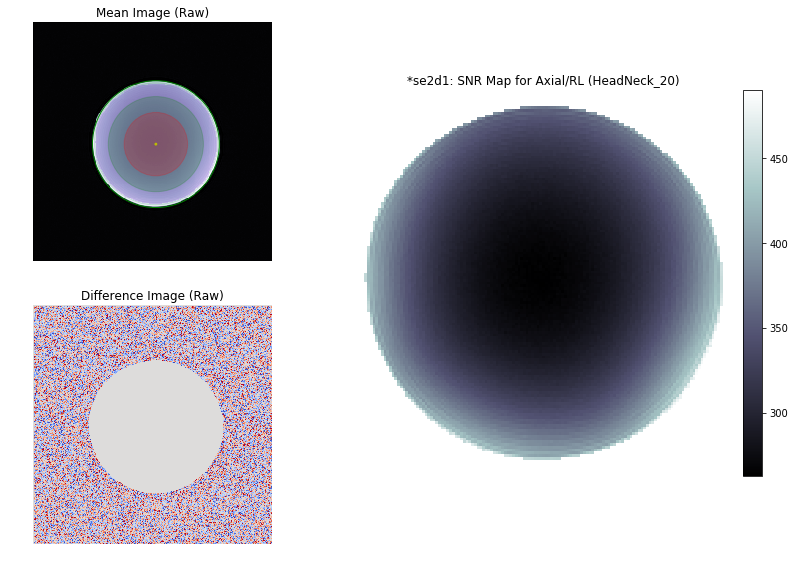

SNR: Raw Images


HeadNeck_20
RegionSize             
0.50              281.0
0.75              304.0

In [26]:
# LONGBOTTLE: Signal to Noise
raw_tra = fetch_series(patid, stuid, sernos=[18, 20])
if len(raw_tra) > 1:
    results = snr_report(raw_dobjs=[raw_tra[0]], raw_dobjsb=[raw_tra[1]])
else:
    results = snr_report(raw_dobjs=[raw_tra[0]])
plt.show()

print('SNR: Raw Images')
with pd.option_context('display.precision', 2):
    display(np.round(results))

These results are similar to the those we have obtained on other 1.5T Siemens scanners under these conditions. Note that 16 elements of the coil (all the head elements but not the neck elements) were used.

In [27]:
NewPage

### Single-element Images
This is the SNR calculated from individual element images combined as a sum of squares. This is the methodology used in the quarterly QA.

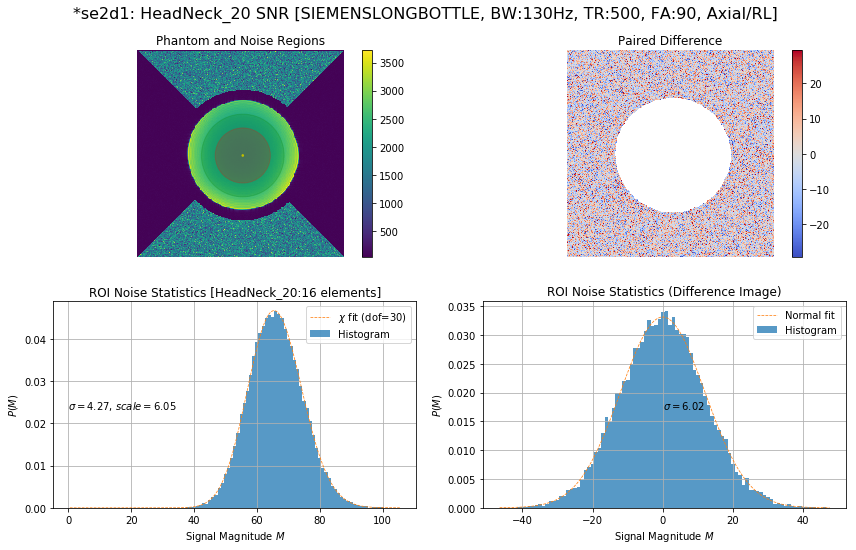

HeadNeck_20
0.50       240.58
0.75       260.11

In [28]:
# SNR (uncombined channels)
from mriqa.dcmio import coil_elements
dobjs = sorted(
    fetch_series(patid, stuid, sernos=[17, 19]),
    key=lambda x: (int(x.SeriesNumber), int(x.AcquisitionNumber), coil_elements(x)[0])
)
nchannels = len(set(coil_elements(d)[0] for d in dobjs))
dobjsa, dobjsb = dobjs[:nchannels], dobjs[nchannels:]

with pd.option_context('display.precision', 2):
    display(snr_report_multi(dobjsa, dobjsb, phantom=SIEMENSLONGBOTTLE))

## Frequency Reference and Transmitter Voltage
These are the reference values reported in the DICOM headers.

In [29]:
dobj = dobjs[0]
csa_tags = csa(dobj)
phoenix_tags = phoenix(dobj)

with pd.option_context('display.precision', 3):
    display(pd.DataFrame({
        'ImagingFrequency': [float(dobj.ImagingFrequency)],
        'TransmitterCalibration': [float(csa_tags['TransmitterCalibration'])],
        'TalesReferencePower': [float(csa_tags['TalesReferencePower'])],
        'GradientSensitivityX': [
            float(phoenix_tags['sGRADSPEC.asGPAData[0].flSensitivityX']) * 1e6,
        ],
        'GradientSensitivityY': [
            float(phoenix_tags['sGRADSPEC.asGPAData[0].flSensitivityY']) * 1e6,
        ],
        'GradientSensitivityZ': [
            float(phoenix_tags['sGRADSPEC.asGPAData[0].flSensitivityZ']) * 1e6
        ]
    }, index=['Value']).T)

Value
ImagingFrequency          63.667
TransmitterCalibration   304.041
TalesReferencePower     1456.311
GradientSensitivityX      92.535
GradientSensitivityY      90.363
GradientSensitivityZ      93.065